In [1]:
import numpy as np
from astropy.io import fits
from loguru import logger
from pathlib import Path

from surfh.Models import instru

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import ndimage

In [3]:
# with fits.open('/home/nmonnier/Data/JWST/NGC_7023/Scan/overwritten_ChannelCube_ch2-shortmediumlong_s3d.fits', mode='update') as hdul1:
#     # Change something in hdul.
#     hdul1[1].data = ndimage.median_filter(hdul1[1].data, axes=[0])
#     hdul1.flush()  # changes are written back to original.fits



hdul = fits.open('/home/nmonnier/Data/JWST/NGC_7023/Scan/ChannelCube_ch2-shortmediumlong_s3d.fits')
data = hdul[1].data

hdr = hdul[1].header
wavel = (np.arange(hdr['NAXIS3']) +hdr['CRPIX3'] - 1) * hdr['CDELT3'] + hdr['CRVAL3']

In [4]:
# Select petite portion de la bar, où il y a de l'information
sel_data = data[:,52:71, 41:60]
nsel_data = sel_data

# Reshape 3D to 2D
spectro = nsel_data.reshape(nsel_data.shape[0],nsel_data.shape[1]*nsel_data.shape[2])

# Create a mask of where the NaNs are
nan_mask = np.isnan(spectro)

# Find the indices of non-NaN values
indices = ndimage.distance_transform_edt(nan_mask, return_distances=False, return_indices=True)

# Replace NaNs with nearest non-NaN values using the indices
filled_image = spectro[tuple(indices)]

Text(0.5, 0, 'Wavelength $\\lambda$')

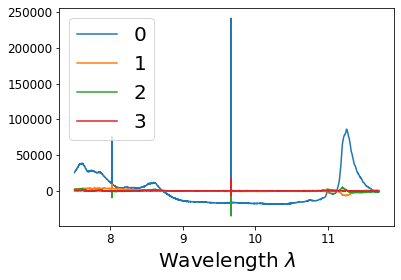

In [5]:
pca = PCA(n_components=4)
principal_components = pca.fit_transform(filled_image)

principal_components = principal_components.T
for i in range(4):
    plt.plot(wavel, principal_components[i], label=i)
plt.legend(fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Wavelength $\lambda$", fontsize=20)

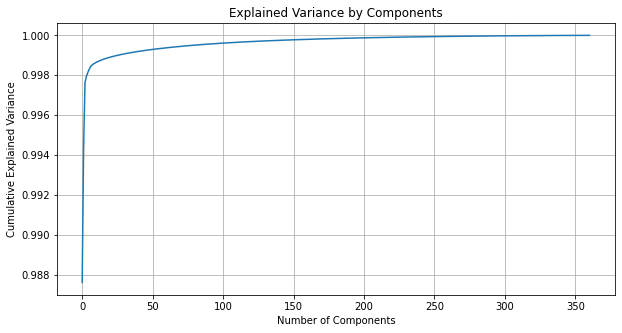

In [6]:
# Perform PCA
pca = PCA()  # Not limiting the number of components
pca.fit(filled_image)

# Explained variance
explained_variance = pca.explained_variance_ratio_
# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)

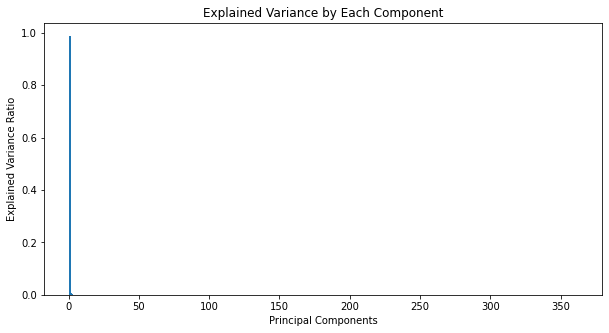

In [7]:
# Optional: Plot the explained variance of individual components
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Component')
# plt.yscale('log')
plt.show()


# Correct bad slices
corrected_filled_image = np.copy(filled_image)
corrected_filled_image[np.where(wavel> 8.990) and np.where(wavel < 9.02)] = filled_image[0]